# [실습] IMDB 데이터셋 분석

GPU 설정


코랩을 활용한다면,
'런타임 -> 런타임 유형 변경' 메뉴에서 GPU를 지정한다.
TensorFlow 버전을 확인하려면 아래 명령문을 실행한다.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.13.0


TensorFlow가 GPU를 사용하는지 여부를 확인하려면 아래 명령문을 실행한다.
아래와 같은 결과가 나오면 GPU가 제대로 지원됨을 의미한다.

```
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
```

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

**IMDB 데이터셋**

In [3]:
from tensorflow.keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

훈련셋, 테스트셋의 크기 모두 25,000이다.

In [4]:
len(train_data)

25000

In [5]:
len(test_data)

25000

각 샘플은 `num_words=10000`에 의해 1~9999 사이의 정수로 이루어진 리스트이다.
최솟값은 1, 최댓값은 9999임은 아래와 같이 확인한다.

In [6]:
min([min(sequence) for sequence in train_data])

1

In [7]:
max([max(sequence) for sequence in train_data])

9999

샘플들의 크기는 서로 다르다.

In [8]:
len(train_data[0])

218

In [9]:
len(train_data[1])

189

0번 샘플의 처음 10개 값은 다음과 같다.

In [10]:
train_data[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

각 샘플의 레이블은 0(부정) 또는 1(긍정)이다.

In [11]:
train_labels[0]

1

In [12]:
test_labels[0]

0

**_영화 후기 내용_**

후기 분류를 위해 반드시 필요한 과정은 아니지만
원한다면 후기의 내용을 확인할 수 있다.
그러기 위해 정수와 단어 사이의 관계를 담은 사전 객체 가져온다.

In [13]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


`word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [14]:
for item in list(word_index.items())[:10]:
    print(item)

('fawn', 34701)
('tsukino', 52006)
('nunnery', 52007)
('sonja', 16816)
('vani', 63951)
('woods', 1408)
('spiders', 16115)
('hanging', 2345)
('woody', 2289)
('trawling', 52008)


정수와 단어의 관계를 서로 바꾼다.

In [15]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

`reverse_word_index`에 포함된 10개 항목을 확인하면 다음과 같다.

In [16]:
for item in list(reverse_word_index.items())[:10]:
    print(item)

(34701, 'fawn')
(52006, 'tsukino')
(52007, 'nunnery')
(16816, 'sonja')
(63951, 'vani')
(1408, 'woods')
(16115, 'spiders')
(2345, 'hanging')
(2289, 'woody')
(52008, 'trawling')


첫째 리뷰 내용을 아래와 같이 확인할 수 있다.
그런데 단어 인덱스에서 3을 빼야 한다.
이유는 0, 1, 2 인덱스는 각각 여백, 문장 시작, 불분명을 의미하기 때문이다.

In [17]:
first_review = train_data[0]

decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in first_review])

decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

**데이터 전처리: 벡터화, 멀티-핫-인코딩**

멀티-핫-인코딩을 이용한 벡터화를 진행하는 함수다.

In [18]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))

    for i, seq in enumerate(sequences):    # 모든 샘플에 대한 멀티-핫-인코딩
        for j in seq:
            results[i, j] = 1.
    return results

훈련셋과 테스트셋를 벡터화한다.

In [19]:
x_train = vectorize_sequences(train_data).astype("float32")
x_test = vectorize_sequences(test_data).astype("float32")

첫째 훈련 샘플의 변환 결과는 다음과 같다.
결과를 보면 원래의 첫째 훈련 샘플에 0은 포함되지 않았지만 1과 2는 사용되었음을 알 수 있다.

In [20]:
x_train[0]

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

실제로 확인해보면 다음과 같다.

In [21]:
0 in train_data[0]

False

In [22]:
1 in train_data[0]

True

In [23]:
2 in train_data[0]

True

레이블 또한 정수 자료형에서 `float32` 자료형으로 변환해서 자료형을 일치시킨다.

In [24]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [25]:
y_train

array([1., 0., 0., ..., 0., 1., 0.], dtype=float32)

In [26]:
y_test

array([0., 1., 1., ..., 0., 0., 0.], dtype=float32)

**모델 구성**

In [27]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

2025-06-02 10:14:06.722625: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-06-02 10:14:06.722659: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-06-02 10:14:06.722671: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-06-02 10:14:06.723084: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-06-02 10:14:06.723404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**모델 컴파일**

In [29]:
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

**모델 훈련**

In [30]:
# 검증 세트
x_val = x_train[:10000]
y_val = y_train[:10000]

# 훈련셋
partial_x_train = x_train[10000:]
partial_y_train = y_train[10000:]

In [31]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20


2025-06-02 10:14:14.994838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7599

2025-06-02 10:14:16.188340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 2s 31ms/step - loss: 0.5459 - accuracy: 0.7599 - val_loss: 0.4291 - val_accuracy: 0.8475
Epoch 2/20
30/30 [==============================] - 0s 9ms/step - loss: 0.3416 - accuracy: 0.8939 - val_loss: 0.3359 - val_accuracy: 0.8725
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.2460 - accuracy: 0.9234 - val_loss: 0.2831 - val_accuracy: 0.8900
Epoch 4/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1925 - accuracy: 0.9381 - val_loss: 0.3044 - val_accuracy: 0.8764
Epoch 5/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1532 - accuracy: 0.9521 - val_loss: 0.2778 - val_accuracy: 0.8890
Epoch 6/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1286 - accuracy: 0.9594 - val_loss: 0.2906 - val_accuracy: 0.8866
Epoch 7/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1061 - accuracy: 0.9689 - val_loss: 0.3115 - val_accuracy: 0.8818
Epoch 8/20
30/30 [============

**`History` 객체 활용**

`history` 속성: 평가지표를 사전 자료형으로 저장

In [32]:
history_dict = history.history

history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

*손실값의 변화*

In [33]:
import matplotlib.pyplot as plt

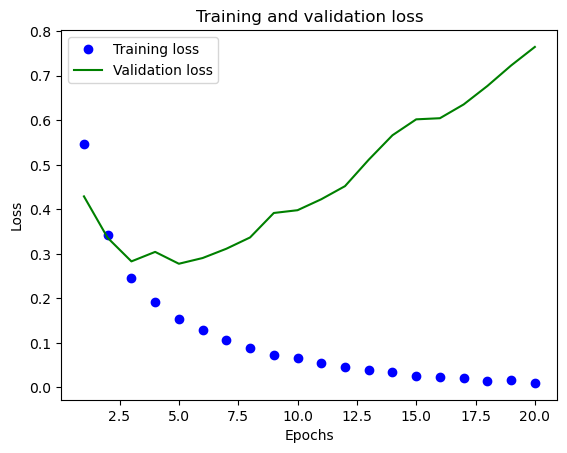

In [34]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "g", label="Validation loss")

plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

*정확도의 변화*

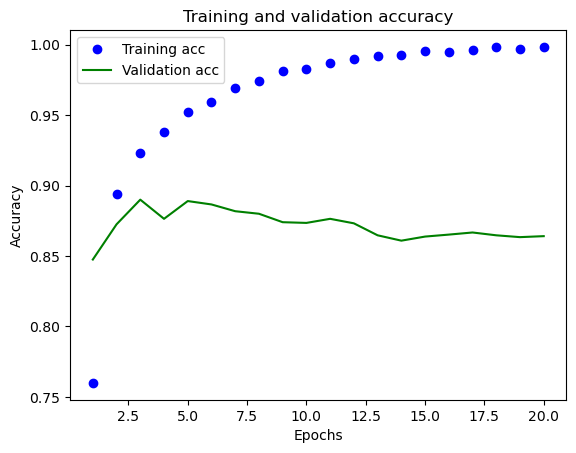

In [35]:
plt.clf()    # 이전 이미지 삭제

acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]

plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "g", label="Validation acc")

plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

**모델 재훈련**

In [36]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)

Epoch 1/4
 1/49 [..............................] - ETA: 15s - loss: 0.7026 - accuracy: 0.4707

2025-06-02 10:16:14.343592: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


49/49 [==============================] - 1s 10ms/step - loss: 0.4693 - accuracy: 0.8168
Epoch 2/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2705 - accuracy: 0.9078
Epoch 3/4
49/49 [==============================] - 0s 6ms/step - loss: 0.2048 - accuracy: 0.9280
Epoch 4/4
49/49 [==============================] - 0s 6ms/step - loss: 0.1727 - accuracy: 0.9404


테스트셋에 대한 성능은 아래와 같이 88% 정도의 정확도를 보인다.

In [37]:
results = model.evaluate(x_test, y_test)
results

 36/782 [>.............................] - ETA: 2s - loss: 0.2673 - accuracy: 0.8898

2025-06-02 10:16:19.507513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 2s 3ms/step - loss: 0.2887 - accuracy: 0.8856


[0.28871315717697144, 0.8855599761009216]

**모델 활용**

훈련된 모델을 활용하려면 `predict()` 메서드를 이용한다.

In [38]:
model.predict(x_test)

130/782 [===>..........................] - ETA: 0s

2025-06-02 10:16:26.161454: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


782/782 [==============================] - 1s 1ms/step


array([[0.19007844],
       [0.99997735],
       [0.8304497 ],
       ...,
       [0.12547423],
       [0.08332945],
       [0.6445802 ]], dtype=float32)

아래처럼 데이터셋이 클 경우 배치 단위로 묶어서 예측할 수도 있다.